In [1]:
# Topology optimization code 
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import sympy as sp
from sympy import *

## Task 1
In the following function, derive the stiffness matrix per element
$$\mathbf{K} = \int_{x,y} \mathbf{B}^\mathrm{T} \mathbf{C} \mathbf{B} \, dxdy$$
by first deriving the matrix for the shape function $\mathbf{B}$
Assumge plane stress condition and thickness is 1

In [2]:
''' Derive and calculate the stiffness matrix
    input:
        varE - Youngs Modulus
        varnu - Poisson's Ratio
        vart - thickness
    output:
        K - a numerical element wise stiffness matrix
'''
def lk(varE,varnu):
    # define symbolic variables
    a, b, x1, x2, nu, E = symbols("a b x_1 x_2 nu E")

    # Shape functions for each node
    N1 = (b-x2)*(a-x1)/(4*a*b)
    N2 = (b-x2)*(a+x1)/(4*a*b)
    N3 = (b+x2)*(a+x1)/(4*a*b)
    N4 = (b+x2)*(a-x1)/(4*a*b)

    Shapefun = Matrix([(N1,N2,N3,N4)])

    # derive the B matrix
    B = zeros(3,8)
    for i in range(4):
        B[0,2*i]   = B[2,2*i+1] = Shapefun[i].diff(x1)
        B[1,2*i+1] = B[2,2*i]   = Shapefun[i].diff(x2)

    # elasticity matrix for plane strain
    C_pStrain = E/((1-2*nu)*(1 + nu))*Matrix([[(1-nu),    nu,           0], 
                                              [    nu, (1-nu),          0], 
                                              [     0,      0, (1-2*nu)/2]])

    # elasticity matrix for plane stress
    C_pStress = E/(1-nu**2)*Matrix([[1,  nu,        0], 
                                    [nu,  1,        0],
                                    [0,   0, (1-nu)/2]])
 
    # stiffness density
    k = B.transpose()*C_pStress*B

    # integrated stiffness
    symK = Matrix([[simplify(integrate(k[i,j],(x1,-a,a),(x2,-b,b)))for i in range (8)] for j in range (8)])

    # substitute in the variables
    numK = symK.subs({a:1,b:1,E:varE,nu:varnu})
    K = np.array(numK).astype(np.float64)
    return K


## Task 2

In [3]:
''' generate mapping matrix between local and global matrix
    input:
        nx - number of elements in the x direction
        ny - number of elements in the y direction
    output:
        edofMat - element dof matrix
'''
def edofMatFun (nx,ny):

    edofMat=np.zeros((nx*ny,8),dtype=int)
    for elx in range(nx):
        for ely in range(ny):
            el = ely+elx*ny
            n1=(ny+1)*elx+ely
            n2=(ny+1)*(elx+1)+ely
            edofMat[el,:]=np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3])

    return edofMat


## Task 3

In [4]:
''' solving for displacement based on updated stiffness
    a new global stiffness matrix is generated at every iteration
    by looping through each element in turn
    input:
        nx - number of elements in the x direction
        ny - number of elements in the y direction
        x  - current iteration optimization density
        penal - exponential penalty
        KE - element wise stiffness
    output:
        U - calculated displacement
'''
def FE(nx, ny, x, penal, KE, edofMat, F, freeDOF, fixedDOF):
    
    ndof = 2*(nx+1)*(ny+1) # Num of dofs
    K = np.zeros([ndof, ndof])
    
    U = np.zeros([ndof])

    for elx in np.arange(nx):
        for ely in np.arange(ny):
            el = ely+elx*ny
            edof = edofMat[el,:]
            
            edofId = np.ix_(edof,edof)
            K[edofId]= K[edofId] + x[ely,elx]**penal*(Emax-Emin)*KE
            
    from scipy import linalg
    
    # solving system of linear equations
    U[np.ix_(freeDOF)]  = linalg.solve(K[np.ix_(freeDOF,freeDOF)], F[np.ix_(freeDOF)])
    U[np.ix_(fixedDOF)] = 0
    
    return U


## Task 4

In [5]:
''' sensitivity filter
    input:
        nx - number of elements in the x direction
        ny - number of elements in the y direction
        x  - current iteration optimization density
        dc - gradient of compliance
        rmin - radius around the element
    output:
        dcn - updated gradient of compliance
'''
def sFilter(nx,ny,x,dc,rmin):
    dcn=np.zeros([ny,nx])
    
    for elx in np.arange(nx):
        for ely in np.arange(ny):

            hf=0.0

            for k in np.arange(max(elx-floor(rmin), 0),min(elx+1+floor(rmin),nx)):
                for l in np.arange(max(ely-floor(rmin),0),min(ely+1+floor(rmin),ny)):
                    dist = rmin-(float((elx-k)**2+(ely-l)**2))**0.5
                    hf += max(0,dist)
                    dcn[ely,elx] += max(0,dist)*x[l,k]*dc[l,k]
            dcn[ely,elx] = dcn[ely,elx]/(x[ely,elx]*hf)
    return dcn

## Task 5

In [10]:
''' Optimality criteria
    input:
        nx - number of elements in the x direction
        ny - number of elements in the y direction
        x  - current iteration optimization density
        dc - gradient of compliance
        volfrac - volume fraction
        Emin - minimize youngs modulus
        Emin - maximum youngs modulus
    output:
        xnew - updated x
'''
def oc(nx,ny,x,dc,volfrac,Emin,Emax):
    l1 = 0
    l2 = 10e9
    move = 0.2
    
    while l2-l1 > 1e-4:
        lmid = 0.5*(l2+l1)
        
        B_e = x*np.sqrt(-dc/lmid)
        xnew = x.copy()
        
        # loop through each element in turn
        for ely in range(ny):
            for elx in range(nx):
                
                if B_e[ely,elx] <= np.max([Emin, x[ely,elx]-move]):
                    xnew[ely,elx] = np.max([Emin, x[ely,elx]-move])
                elif np.min([Emax, x[ely,elx]+move])<=B_e[ely,elx]:
                    xnew[ely,elx]=np.min([Emax, x[ely,elx]+move])
                else:
                    xnew[ely,elx] = B_e[ely,elx]

        if np.sum(xnew) - volfrac*nx*ny > 0:
            l1 = lmid
        else:
            l2 = lmid
    return xnew

## Task 6

In [13]:
# Input parameters #
nx=60
ny=30
volfrac=0.25
rmin=2
penal=3
nu   = 0.3 # Poisson's ratio
Emax = 1.0 # Maximum youngs modulus
Emin = 1e-4 # Minimum youngs modulus


print("Minimum compliance problem with Optimality criterion")
print("ndes: " + str(nx) + " x " + str(ny))
print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal) +'\n')

# Allocate design variables (as array)
# Store density from each iteration
xList = []
# initialize the array at the specified density
x=volfrac * np.ones([ny,nx])
xList.append(x)

dc=np.zeros([ny,nx]) # storing gradient

change  = 1 # total change in density
counter = 0 # counter for iteration

ndof = 2*(nx+1)*(ny+1) # Num of dofs

# Derive the element stiffness matrix
KE=lk(Emax,nu)

# Calculating the local to global matrix
edofMat = edofMatFun (nx,ny)

# number of dofs
ndof = 2*(nx+1)*(ny+1)

# count of all the dofs
dofs  = np.arange(ndof)

# Initialize initial force vector
F = np.zeros([ndof])

# Assign boundary condition
#F[1]=-1
F[2*(nx+1)*(ny+1)-1-ny]= - 1

# symmetry boundary condition on the left side, and simple support in the y direction on the right
#fixed = np.union1d(dofs[0:2*(ny+1):2],np.array([2*(nx+1)*(ny+1)-1-ny*2]))
fixed = dofs[0:2*(ny+1)]

# free dof is all that's not in fixed
free  = np.setdiff1d(dofs,fixed)

while change>0.05 and counter<200:
    xold = x.copy()

    # find global displacement
    U = FE(nx,ny,x,penal,KE,edofMat, F, free, fixed) 

    # Objective function and sensitivity analysis
    c = 0.0 # compliance

    # loop through each element in turn
    for ely in range(ny):
        for elx in range(nx):
            # get the row associated with the local element el
            el = ely+elx*ny
            edof = edofMat[el,:]

            # getting the sub displacement array for element [elx,ely]
            Ue = U[np.ix_(edof)]
            
            # summing the compliance
            c = c + Emin + x[ely,elx]**penal*(Emax-Emin)*np.transpose(Ue)@(KE@Ue)
            
            # calculating the gradient of the compliance
            dc[ely,elx]= - penal*x[ely,elx]**(penal-1)*(Emax-Emin)*np.transpose(Ue)@(KE@Ue) # gradient of c

    # apply sensitive filter
    dc = sFilter(nx, ny, x, dc, rmin)
    
    # use optimality criteria to calculate the next x
    x  = oc(nx, ny, x, dc, volfrac, Emin,Emax)
    xList.append(x)

    # calculate change in density
    change = np.max(np.max(np.abs(x-xold)))

    # Write iteration history to screen (req. Python 2.6 or newer)
    print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(counter, c, np.sum(x)/(nx*ny),change))
    counter+=1


Minimum compliance problem with Optimality criterion
ndes: 60 x 30
volfrac: 0.25, rmin: 2, penal: 3

it.: 0 , obj.: 2531.168 Vol.: 0.250, ch.: 0.200
it.: 1 , obj.: 1541.934 Vol.: 0.250, ch.: 0.200
it.: 2 , obj.: 1029.566 Vol.: 0.250, ch.: 0.200
it.: 3 , obj.: 829.313 Vol.: 0.250, ch.: 0.200
it.: 4 , obj.: 715.226 Vol.: 0.250, ch.: 0.200
it.: 5 , obj.: 629.649 Vol.: 0.250, ch.: 0.200
it.: 6 , obj.: 568.032 Vol.: 0.250, ch.: 0.200
it.: 7 , obj.: 499.548 Vol.: 0.250, ch.: 0.200
it.: 8 , obj.: 443.577 Vol.: 0.250, ch.: 0.176
it.: 9 , obj.: 381.200 Vol.: 0.250, ch.: 0.200
it.: 10 , obj.: 323.487 Vol.: 0.250, ch.: 0.200
it.: 11 , obj.: 276.231 Vol.: 0.250, ch.: 0.191
it.: 12 , obj.: 239.843 Vol.: 0.250, ch.: 0.200
it.: 13 , obj.: 218.640 Vol.: 0.250, ch.: 0.161
it.: 14 , obj.: 203.431 Vol.: 0.250, ch.: 0.176
it.: 15 , obj.: 195.114 Vol.: 0.250, ch.: 0.144
it.: 16 , obj.: 189.004 Vol.: 0.250, ch.: 0.160
it.: 17 , obj.: 185.578 Vol.: 0.250, ch.: 0.136
it.: 18 , obj.: 183.005 Vol.: 0.250, ch.: 

## Task 7

<ipython-input-14-7cfdfe952efc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


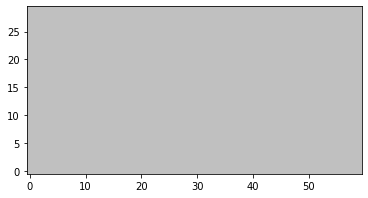

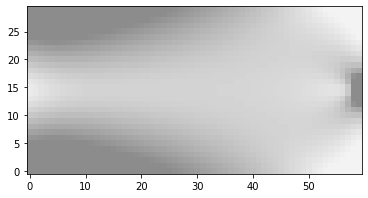

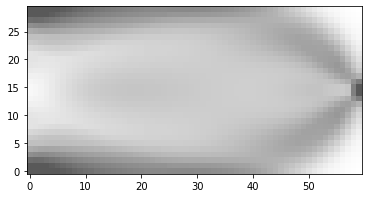

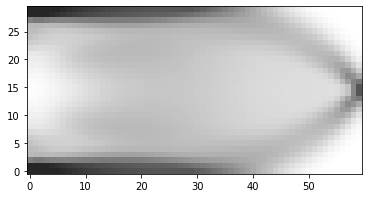

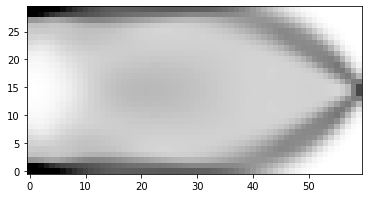

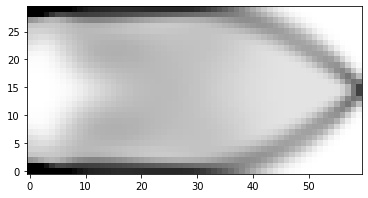

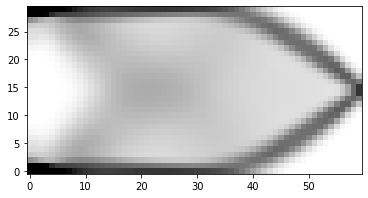

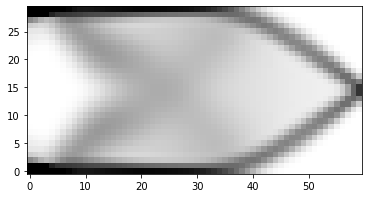

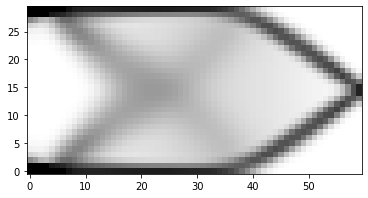

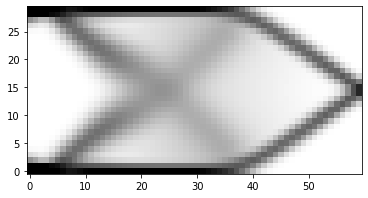

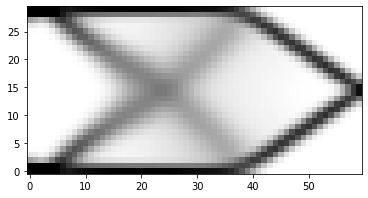

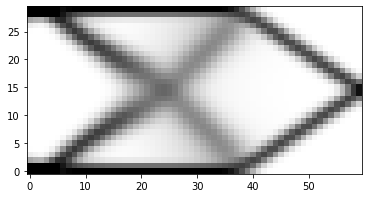

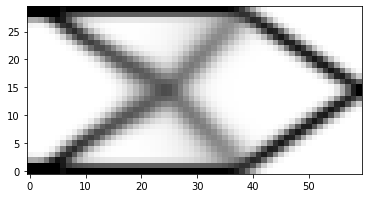

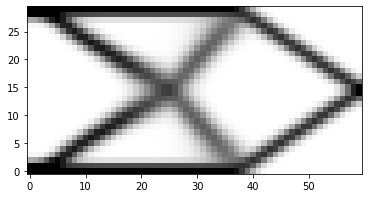

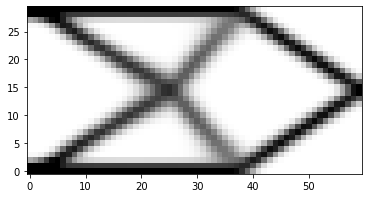

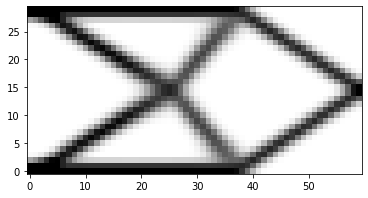

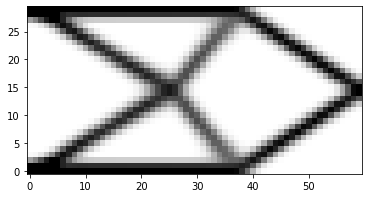

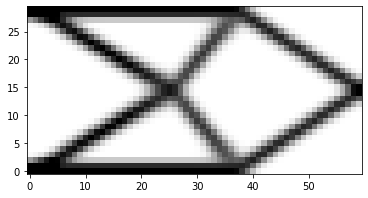

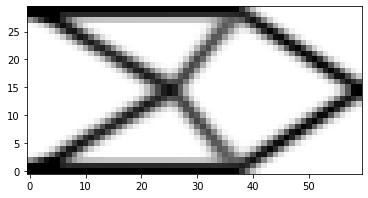

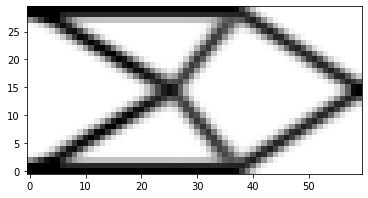

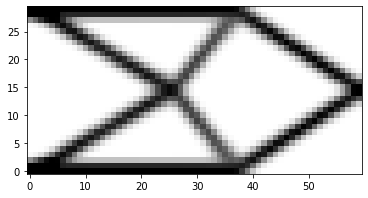

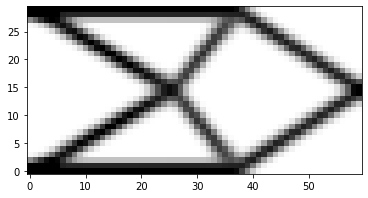

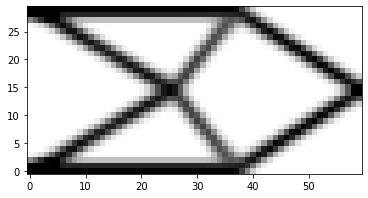

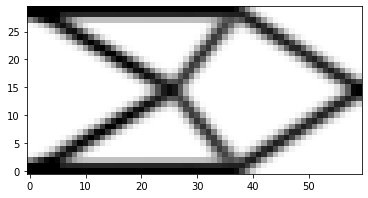

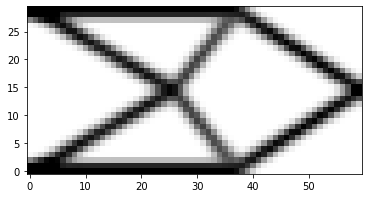

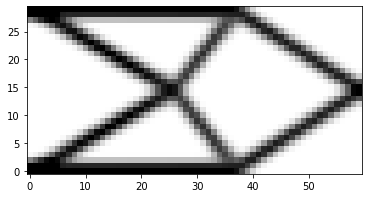

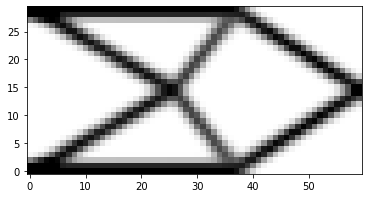

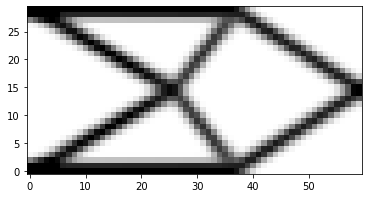

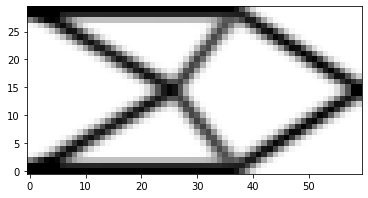

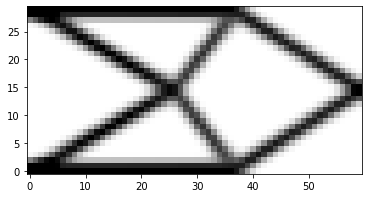

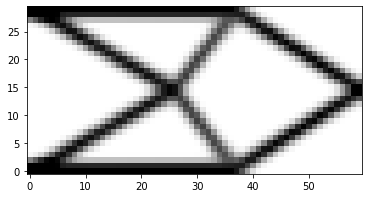

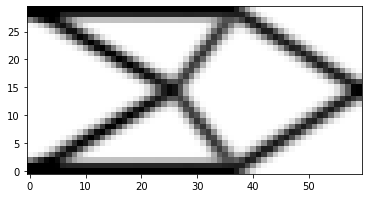

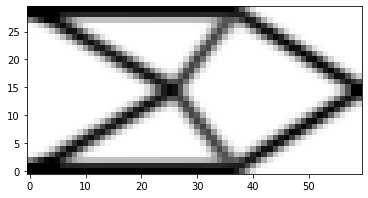

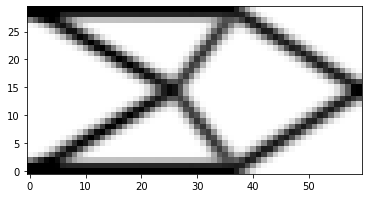

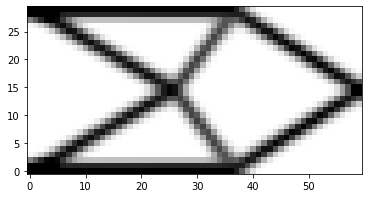

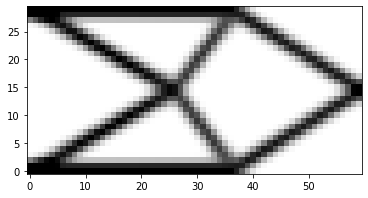

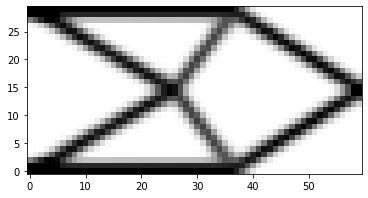

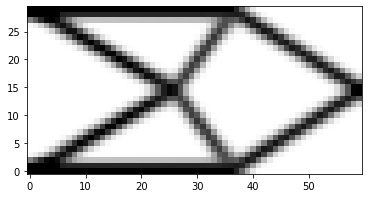

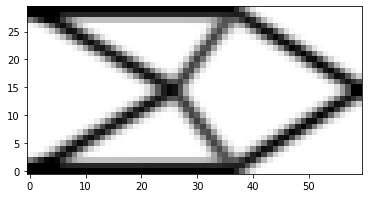

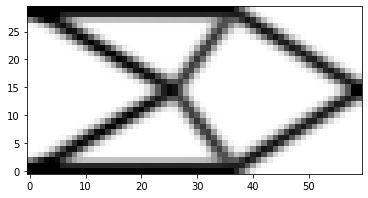

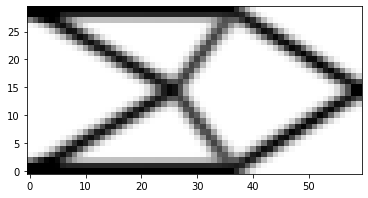

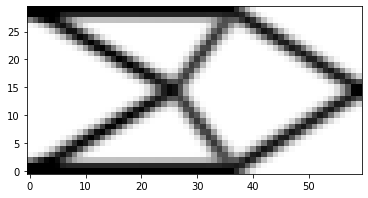

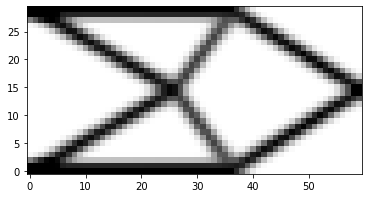

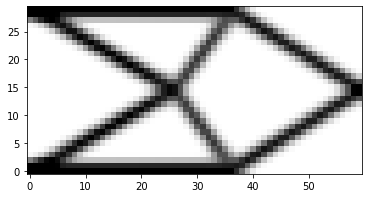

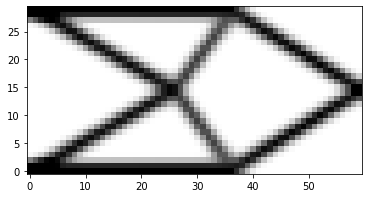

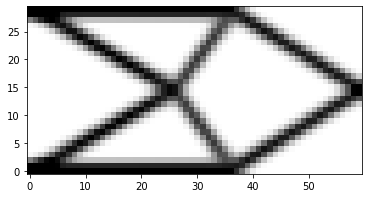

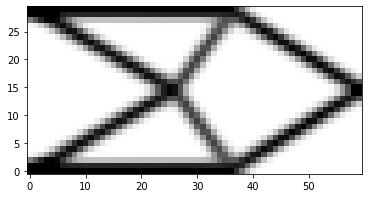

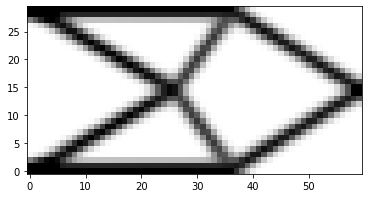

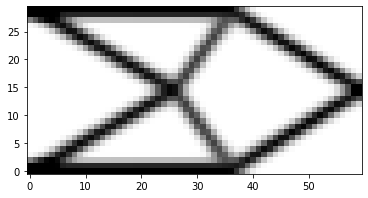

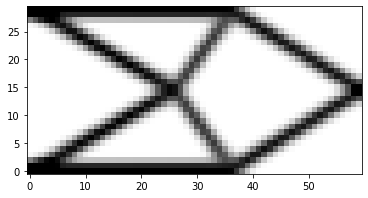

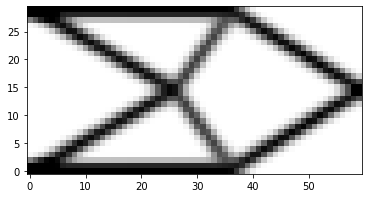

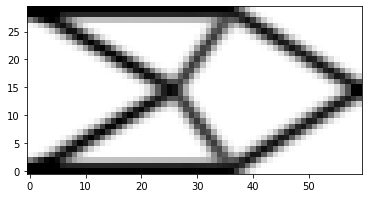

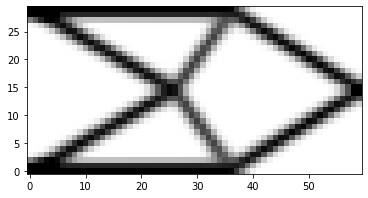

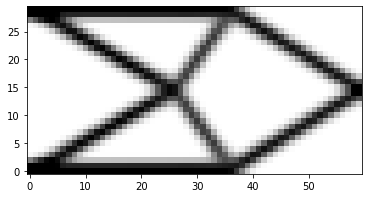

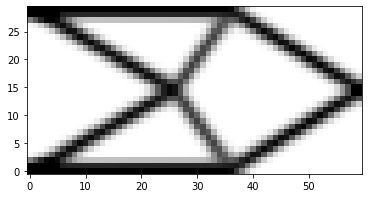

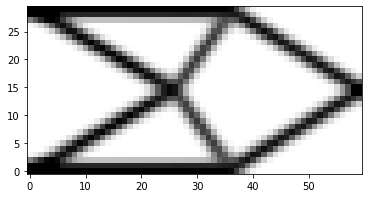

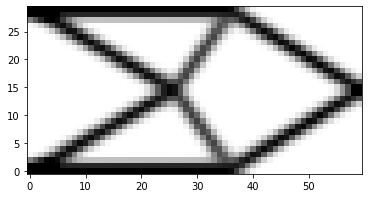

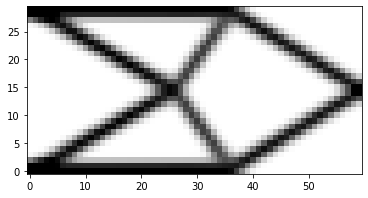

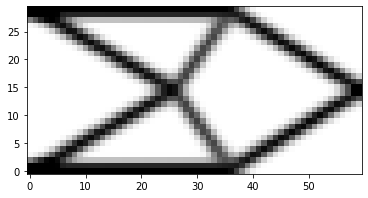

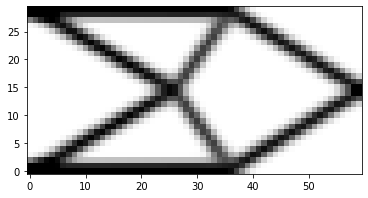

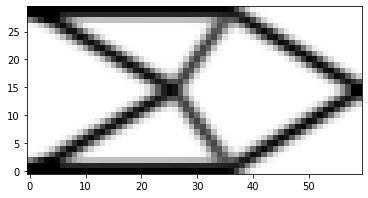

In [14]:
# Plot the density function
for i,x in enumerate(xList):
    fig,ax = plt.subplots()
    ax.imshow(-x.reshape((ny,nx)),origin='lower', cmap='gray', interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
    if i<10:
        plt.savefig('frames/f_nx-'+str(nx)+'_ny-'+str(ny)+'_f-00'+str(i)+'.png')
    if i<100:
        plt.savefig('frames/f_nx-'+str(nx)+'_ny-'+str(ny)+'_f-0'+str(i)+'.png')
    else:
        plt.savefig('frames/f_nx-'+str(nx)+'_ny-'+str(ny)+'_f-'+str(i)+'.png')
plt.close()